In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

cwd = os.getcwd()
sys.path.append(os.path.join(cwd, '..'))
#from warehouse_agent_att_viz import *
from warehouse_agent_optuna import *


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#checkpoint_path = "agent_checkpoint.pth"
agent_name = "agent_optuna_final_run2.pth"

# Load checkpoint
checkpoint = torch.load(os.path.abspath(os.path.join(cwd, '..\\agents', agent_name)), weights_only=True, map_location=device)

# Extract training arguments from checkpoint (or use defaults if not found)
training_args = checkpoint["training_args"]
training_args['device'] = device # override with current device


print("Loaded Training Arguments:")
for key, value in training_args.items():
    print(f"\t{key}: {value}")

# Initialize the environment and agent using the loaded training arguments
env = WarehouseEnvironment(
    num_items=training_args['num_items'],
    num_q_dims=training_args['num_q_dims'],
    k=training_args['k'],
    init_max_steps=training_args['init_max_steps']
)

agent = DQNAgent(
        num_q_dims=training_args['num_q_dims'],
        epsilon_min=training_args['epsilon_min'],
        epsilon_decay=training_args['epsilon_decay'],
        learning_rate=training_args['learning_rate'],
        gamma=training_args['gamma'],
        hidden_dim=training_args['hidden_dim'],
        n_heads=training_args['n_heads'],
        n_layers=training_args['n_layers'],
        device=training_args['device']
    )
agent.model.load_state_dict(checkpoint["model_state_dict"])

# Set the model to evaluation mode
agent.model.eval()

Loaded Training Arguments:
	num_episodes: 50000
	batch_size: 64
	init_max_steps: 16
	max_steps_update_freq: 30000
	epsilon_min: 0.01
	num_items: 50
	num_q_dims: 1
	k: 3
	device: cpu
	learning_rate: 5.989635826278099e-05
	gamma: 0.9299662258435576
	hidden_dim: 256
	n_heads: 4
	n_layers: 3
	target_update_freq: 15
	epsilon_decay: 0.9952048696658744


AttentionQNetwork(
  (embedding): Linear(in_features=5, out_features=256, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (q_head): Linear(in_features=256, out_features=1, bias=True)
)

In [3]:
def random_agent(state):
    available_items = np.where(state[:,0] == 1)[0]
    action = np.random.choice(available_items)
    return action

In [7]:

def run_loop(action_fn, env, init_state, log_key, logs):
    state = init_state
    done = False
    total_reward = 0
    step = 1
    while not done:
        # action_fn can be a method or a function that takes state as input
        action = action_fn(state)
        if action is None:
            break
        next_state, reward, done = env.step(action)
        total_reward += reward
        state = next_state

        if env.group_completed:
            group_qualities = env.qualities[env.current_group]
            variances_per_dim = np.var(group_qualities, axis=0)
            sum_variances = np.sum(variances_per_dim)
            means_per_dim = np.mean(group_qualities, axis=0)
            sum_means = np.sum(means_per_dim)
            logs[log_key]['vars'].append(sum_variances)
            logs[log_key]['means'].append(sum_means)
            logs[log_key]['rewards'].append(reward)
            
            print(f"Step {step} | Action: {[int(x) for x in env.current_group]}, Reward: {reward} | mean: {sum_means:.3f}, var: {sum_variances:.3f}")
            step += 1
            env.reset_group()
    return total_reward

# Define the logs dictionary
logs = {
    'agent': {'means': [], 'vars': [], 'rewards': []},
    'random': {'means': [], 'vars': [], 'rewards': []}
}

init_state = env.reset() # use same initial state for both agents
total_reward_agent = run_loop(agent.act, env, init_state, 'agent', logs)
env.reset_availability()
total_reward_random = run_loop(random_agent, env, init_state, 'random', logs)

print(f"Total reward for DQN agent: {total_reward_agent}")
print(f"Total reward for random agent: {total_reward_random}")


Step 1 | Action: [18, 10, 30], Reward: -0.08079499751329422 | mean: 0.665, var: 0.081
Step 2 | Action: [17, 32, 28], Reward: -0.31964588165283203 | mean: 0.469, var: 0.123
Step 3 | Action: [43, 37, 4], Reward: -0.13644498586654663 | mean: 0.396, var: 0.063
Step 4 | Action: [46, 45, 35], Reward: -0.24922417104244232 | mean: 0.596, var: 0.049
Step 5 | Action: [6, 33, 48], Reward: -0.39538058638572693 | mean: 0.202, var: 0.001
Step 6 | Action: [19, 2, 42], Reward: -0.050704650580883026 | mean: 0.253, var: 0.000
Step 7 | Action: [34, 0, 5], Reward: -0.04812535271048546 | mean: 0.206, var: 0.002
Step 8 | Action: [22, 24, 11], Reward: -0.07334984093904495 | mean: 0.280, var: 0.000
Step 9 | Action: [14, 25, 9], Reward: -0.46699243783950806 | mean: 0.658, var: 0.089
Step 10 | Action: [36, 41, 47], Reward: -0.10262564569711685 | mean: 0.673, var: 0.087
Step 11 | Action: [7, 20, 31], Reward: -0.12526029348373413 | mean: 0.600, var: 0.052
Step 12 | Action: [49, 26, 1], Reward: -0.2368410378694534

In [11]:
logs['random']

{'means': [np.float32(0.16269805)],
 'vars': [np.float32(0.0021963974)],
 'rewards': [np.float32(-0.14932336)]}

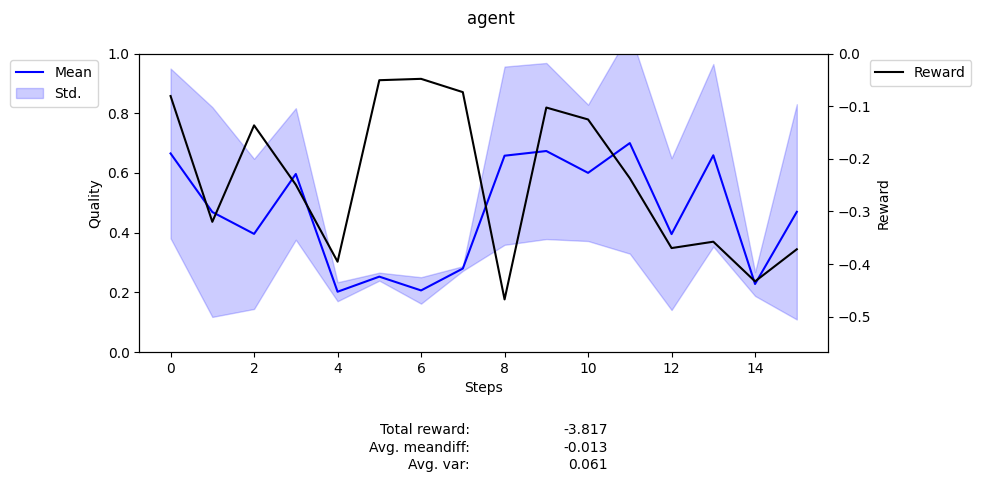

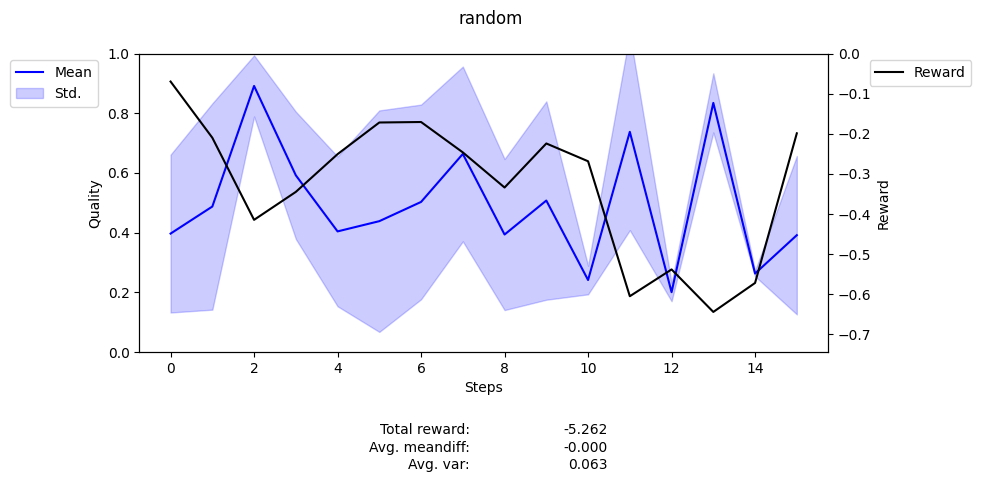

In [8]:
def plot_mean_variance(logs, name):

    logs = logs[name]
    means = logs['means']
    variances = logs['vars']
    rewards = logs['rewards']
    steps = np.arange(len(means))
    std = np.sqrt(variances)
    

    # Create subplots
    fig, (ax11,ax2) = plt.subplots(nrows=2, figsize=(10, 5), height_ratios=[4, 1])
    fig.suptitle(name)
    ax12 = ax11.twinx()

    # First subplot: Mean and confidence interval
    ax11.plot(steps, means, color='blue', label='Mean')
    ax11.fill_between(steps, means - std, means + std, color='blue', alpha=0.2, label='Std.')
    ax11.set_xlabel('Steps')
    ax11.set_ylabel('Quality')
    ax11.set_ylim([0, 1])

    # Second subplot: reward
    ax12.plot(steps, rewards, color='black', label='Reward')
    ax12.set_xlabel('Steps')
    ax12.set_ylabel('Reward')
    ax12.set_ylim([min(rewards)-0.1, 0])

    # Add legend
    ax11.legend(loc='upper right', bbox_to_anchor=(-0.05, 1))
    ax12.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

    # Add table with statistics
    data = [
        ["Total reward:", f"{sum(rewards):.3f}"],
        ["Avg. meandiff:", f"{np.mean(np.diff(means)):.3f}"],
        ["Avg. var:", f"{np.mean(variances):.3f}"]
    ]
    table = ax2.table(cellText=data, loc='center')
    table.scale(0.4, 1)
    ax2.axis('off')
    for _, cell in table.get_celld().items():
        cell.set_linewidth(0)

    # Adjust layout
    plt.tight_layout()
    plt.show()


# Call the function with the example data
plot_mean_variance(logs, 'agent')
plot_mean_variance(logs, 'random')


In [37]:
env.qualities

NameError: name 'env' is not defined

In [24]:
available_items = np.where(state[:,0] == 0)[0]
action = np.random.choice(available_items)

In [25]:
action

np.int64(4)

In [26]:
def random_agent(state):
    available_items = np.where(state[:,0] == 0)[0]
    action = np.random.choice(available_items)
    return action

In [44]:
random_agent(state)

np.int64(49)

In [12]:
env.qualities

array([[0.16489613],
       [0.72969943],
       [0.60957843],
       [0.7358874 ],
       [0.72599137],
       [0.15394698],
       [0.38464528],
       [0.16183987],
       [0.36529928],
       [0.14471312],
       [0.14978386],
       [0.9546566 ],
       [0.94643384],
       [0.58282554],
       [0.9566915 ],
       [0.9455599 ],
       [0.5860073 ],
       [0.3692884 ],
       [0.9763092 ],
       [0.5932771 ],
       [0.9519365 ],
       [0.9436808 ],
       [0.35930136],
       [0.7217784 ],
       [0.94441956],
       [0.16496196],
       [0.16356862],
       [0.15736294],
       [0.14721273],
       [0.73037636],
       [0.36882633],
       [0.6074761 ],
       [0.36873135],
       [0.9293181 ],
       [0.37733054],
       [0.6063955 ],
       [0.72665745],
       [0.7414683 ],
       [0.60084486],
       [0.5885677 ],
       [0.72563833],
       [0.7349042 ],
       [0.62644166],
       [0.6105949 ],
       [0.94329023],
       [0.3840438 ],
       [0.38270456],
       [0.348

In [11]:
state

array([[1.        , 0.16489613, 0.518416  , 0.        , 0.02930393],
       [0.        , 0.72969943, 0.04638731, 0.        , 0.02930393],
       [0.        , 0.60957843, 0.07373369, 0.        , 0.02930393],
       [1.        , 0.7358874 , 0.05257529, 0.        , 0.02930393],
       [0.        , 0.72599137, 0.04267925, 0.        , 0.02930393],
       [0.        , 0.15394698, 0.5293651 , 0.        , 0.02930393],
       [1.        , 0.38464528, 0.29866683, 0.        , 0.02930393],
       [0.        , 0.16183987, 0.5214722 , 0.        , 0.02930393],
       [1.        , 0.36529928, 0.31801283, 0.        , 0.02930393],
       [0.        , 0.14471312, 0.538599  , 0.        , 0.02930393],
       [0.        , 0.14978386, 0.53352827, 0.        , 0.02930393],
       [0.        , 0.9546566 , 0.27134448, 0.        , 0.02930393],
       [0.        , 0.94643384, 0.26312172, 0.        , 0.02930393],
       [0.        , 0.58282554, 0.10048658, 0.        , 0.02930393],
       [1.        , 0.9566915 , 0.

In [14]:
state[:,0]

array([1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.],
      dtype=float32)

In [15]:
np.where(state[:,0] == 0)[0]

array([ 1,  2,  4,  5,  7,  9, 10, 11, 12, 13, 16, 17, 19, 21, 26, 27, 28,
       29, 30, 32, 34, 36, 37, 40, 41, 42, 44, 45, 46, 49])